In [1]:
import glob
import os
import time

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.metrics import mape
from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from pytorch_lightning.utilities.model_summary import summarize


from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
from itertools import product
from typing import Optional


from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae, mase, rmse
from darts.models import (
    ARIMA,
    ExponentialSmoothing,
    KalmanForecaster,
    LightGBMModel,
    LinearRegressionModel,
    NaiveSeasonal,
    NBEATSModel,
    RandomForest,
    TransformerModel,
    RNNModel
)
from darts.utils.losses import SmapeLoss, MAELoss

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [23]:
def read_data(folder_path: str) -> list[tuple[str, TimeSeries]]:
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    series = []
    for csv in csv_files:
        data = pd.read_csv(csv)
        data["Time"] = pd.to_datetime(data["Time"])
        data["time_idx"] = (data["Time"].astype(int) // 10**9) // 300
        data["time_idx"] -= data["time_idx"].min()
        data["hour"] = data["Time"].dt.hour
        data = data.drop(columns=["Time"])
        
        ts = TimeSeries.from_dataframe(data, time_col="time_idx")
        patient_id = os.path.basename(csv).replace(".csv", "")
        series.append((patient_id, ts))
    
    return series

In [69]:
n = len(cgm_series)
k = 10  # number of blocks
block_size = n // k

splits = []

for i in range(1, k):
    train = cgm_series[:i * block_size]
    test = cgm_series[i * block_size:(i + 1) * block_size]
    splits.append((train, test))

# Now `splits` contains 9 train/test folds (Fold 1 uses block 0 for training and block 1 for testing, etc.)

# Optional: print shapes
for idx, (train, test) in enumerate(splits):
    print(f"Fold {idx + 1}:")
    print(f"Train: {train.start_time()} to {train.end_time()}  | Length: {len(train)}")
    print(f"Test : {test.start_time()} to {test.end_time()}    | Length: {len(test)}")
    print("-----------")

Fold 1:
Train: 0 to 863  | Length: 864
Test : 864 to 1727    | Length: 864
-----------
Fold 2:
Train: 0 to 1727  | Length: 1728
Test : 1728 to 2591    | Length: 864
-----------
Fold 3:
Train: 0 to 2591  | Length: 2592
Test : 2592 to 3455    | Length: 864
-----------
Fold 4:
Train: 0 to 3455  | Length: 3456
Test : 3456 to 4319    | Length: 864
-----------
Fold 5:
Train: 0 to 4319  | Length: 4320
Test : 4320 to 5183    | Length: 864
-----------
Fold 6:
Train: 0 to 5183  | Length: 5184
Test : 5184 to 6047    | Length: 864
-----------
Fold 7:
Train: 0 to 6047  | Length: 6048
Test : 6048 to 6911    | Length: 864
-----------
Fold 8:
Train: 0 to 6911  | Length: 6912
Test : 6912 to 7775    | Length: 864
-----------
Fold 9:
Train: 0 to 7775  | Length: 7776
Test : 7776 to 8639    | Length: 864
-----------


# Clarckes Error Grid

In [16]:
zone_names = ['A', 'B', 'C', 'D', 'E']
def clarke_error_grid(ref_values, pred_values, title_string):

    #Checking to see if the lengths of the reference and prediction arrays are the same
    assert (len(ref_values) == len(pred_values)), "Unequal number of values (reference : {}) (prediction : {}).".format(len(ref_values), len(pred_values))

    #Checks to see if the values are within the normal physiological range, otherwise it gives a warning
    if max(ref_values) > 400 or max(pred_values) > 400:
        print("Input Warning: the maximum reference value {} or the maximum prediction value {} exceeds the normal physiological range of glucose (<400 mg/dl).".format(max(ref_values), max(pred_values)))
    if min(ref_values) < 0 or min(pred_values) < 0:
        print("Input Warning: the minimum reference value {} or the minimum prediction value {} is less than 0 mg/dl.".format(min(ref_values),  min(pred_values)))

    #Clear plot
    plt.clf()

    #Set up plot
    plt.scatter(ref_values, pred_values, marker='o', color='black', s=8)
    plt.title(title_string + " Clarke Error Grid")
    plt.xlabel("Reference Concentration (mg/dl)")
    plt.ylabel("Prediction Concentration (mg/dl)")
    plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.gca().set_facecolor('white')

    #Set axes lengths
    plt.gca().set_xlim([0, 400])
    plt.gca().set_ylim([0, 400])
    plt.gca().set_aspect((400)/(400))

    #Plot zone lines
    plt.plot([0,400], [0,400], ':', c='black')                      #Theoretical 45 regression line
    plt.plot([0, 175/3], [70, 70], '-', c='black')
    #plt.plot([175/3, 320], [70, 400], '-', c='black')
    plt.plot([175/3, 400/1.2], [70, 400], '-', c='black')           #Replace 320 with 400/1.2 because 100*(400 - 400/1.2)/(400/1.2) =  20% error
    plt.plot([70, 70], [84, 400],'-', c='black')
    plt.plot([0, 70], [180, 180], '-', c='black')
    plt.plot([70, 290],[180, 400],'-', c='black')
    # plt.plot([70, 70], [0, 175/3], '-', c='black')
    plt.plot([70, 70], [0, 56], '-', c='black')                     #Replace 175.3 with 56 because 100*abs(56-70)/70) = 20% error
    # plt.plot([70, 400],[175/3, 320],'-', c='black')
    plt.plot([70, 400], [56, 320],'-', c='black')
    plt.plot([180, 180], [0, 70], '-', c='black')
    plt.plot([180, 400], [70, 70], '-', c='black')
    plt.plot([240, 240], [70, 180],'-', c='black')
    plt.plot([240, 400], [180, 180], '-', c='black')
    plt.plot([130, 180], [0, 70], '-', c='black')

    #Add zone titles
    plt.text(30, 15, "A", fontsize=15)
    plt.text(370, 260, "B", fontsize=15)
    plt.text(280, 370, "B", fontsize=15)
    plt.text(160, 370, "C", fontsize=15)
    plt.text(160, 15, "C", fontsize=15)
    plt.text(30, 140, "D", fontsize=15)
    plt.text(370, 120, "D", fontsize=15)
    plt.text(30, 370, "E", fontsize=15)
    plt.text(370, 15, "E", fontsize=15)

    #Statistics from the data
    zone = [0] * 5
    for i in range(len(ref_values)):
        if (ref_values[i] <= 70 and pred_values[i] <= 70) or (pred_values[i] <= 1.2*ref_values[i] and pred_values[i] >= 0.8*ref_values[i]):
            zone[0] += 1    #Zone A

        elif (ref_values[i] >= 180 and pred_values[i] <= 70) or (ref_values[i] <= 70 and pred_values[i] >= 180):
            zone[4] += 1    #Zone E

        elif ((ref_values[i] >= 70 and ref_values[i] <= 290) and pred_values[i] >= ref_values[i] + 110) or ((ref_values[i] >= 130 and ref_values[i] <= 180) and (pred_values[i] <= (7/5)*ref_values[i] - 182)):
            zone[2] += 1    #Zone C
        elif (ref_values[i] >= 240 and (pred_values[i] >= 70 and pred_values[i] <= 180)) or (ref_values[i] <= 175/3 and pred_values[i] <= 180 and pred_values[i] >= 70) or ((ref_values[i] >= 175/3 and ref_values[i] <= 70) and pred_values[i] >= (6/5)*ref_values[i]):
            zone[3] += 1    #Zone D
        else:
            zone[1] += 1    #Zone B

    return plt, zone


def evaluate_clarke_error(predictions, actuals, scaler=None, model_name="model", save_file=None):
    all_predicted = []
    all_actual = []

    for pred_series, actual_series in zip(predictions, actuals):
        # actual_matched = actual_series[:len(pred_series)]
        actual_matched = actual_series.slice_intersect(pred_series)

        if scaler is not None:
            pred_unscaled = scaler.inverse_transform(pred_series)
            actual_unscaled = scaler.inverse_transform(actual_matched)
        
            all_predicted.extend(pred_unscaled.values().flatten())
            all_actual.extend(actual_unscaled.values().flatten())
        else:
            all_predicted.extend(pred_series.values().flatten())
            all_actual.extend(actual_series.values().flatten())

    all_actual = np.array(all_actual)
    all_predicted = np.array(all_predicted)

    # clarke_zones = zone_accuracy(all_actual, all_predicted, mode='clarke')
    # zone_names = ['A', 'B', 'C', 'D', 'E']

    print(f"\nClarke Error Grid for {model_name}:")
    plt, clarke_zones = clarke_error_grid(all_actual, all_predicted, model_name)
    sum_zones = sum(clarke_zones)
    for i, zone in enumerate(zone_names):
        result_str = f"Zone {zone}: {(clarke_zones[i] / sum_zones )*100:.2f}%"
        print(result_str)
        if save_file:
            save_file.write(result_str + "\n")
    
    return plt, clarke_zones


# Cross validation all data

In [6]:
def read_data(folder_path: str) -> tuple:
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    series = []
    patient_ids = []
    count = 0
    
    excluded_patients = ["child#001", "adult#001", "adolescent#001"]
    
    for csv in csv_files:
        patient_id = os.path.basename(csv).split('.')[0]
        
        if any(excluded in patient_id for excluded in excluded_patients):
            print(f"Excluding {patient_id}")
            continue
        
        data = pd.read_csv(csv)
        data["Time"] = pd.to_datetime(data["Time"])
        data["time_idx"] = (data["Time"].astype(int) // 10**9) // 300
        data["time_idx"] -= data["time_idx"].min()
        data["hour"] = data["Time"].dt.hour
        data = data.drop(columns=["Time"])
        print(csv)
        print(count)
        count += 1
        series.append(TimeSeries.from_dataframe(data, time_col="time_idx"))
        patient_ids.append(patient_id)
        
    return series, patient_ids

def create_future_covariates(ts: TimeSeries):
    basal_insulin = ts['basal_insulin']
    hour = ts['hour']
    covariates = basal_insulin.stack(hour)
    return covariates

def create_past_covariates(ts: TimeSeries):
    bolus_insulin = ts["bolus_insulin"]
    cho = ts["CHO"]
    covariates = bolus_insulin.stack(cho)
    return covariates
    

In [7]:
folder_path = "results/2025-03-29_17-22-25/processed/"

series, patient_ids = read_data(folder_path)
cgm_series = [ts["CGM"] for ts in series]
future_covariates = [create_future_covariates(ts).astype(np.float32) for ts in series]
past_covariates = [create_past_covariates(ts).astype(np.float32) for ts in series]

results/2025-03-29_17-22-25/processed/child#004.csv
0
results/2025-03-29_17-22-25/processed/child#010.csv
1
results/2025-03-29_17-22-25/processed/adolescent#009.csv
2
results/2025-03-29_17-22-25/processed/adult#008.csv
3
results/2025-03-29_17-22-25/processed/child#005.csv
4
results/2025-03-29_17-22-25/processed/adult#002.csv
5
results/2025-03-29_17-22-25/processed/adolescent#004.csv
6
results/2025-03-29_17-22-25/processed/adolescent#006.csv
7
results/2025-03-29_17-22-25/processed/adult#009.csv
8
results/2025-03-29_17-22-25/processed/adult#007.csv
9
results/2025-03-29_17-22-25/processed/adolescent#003.csv
10
Excluding adult#001
Excluding adolescent#001
results/2025-03-29_17-22-25/processed/adolescent#010.csv
11
results/2025-03-29_17-22-25/processed/adult#006.csv
12
results/2025-03-29_17-22-25/processed/adult#005.csv
13
results/2025-03-29_17-22-25/processed/adult#010.csv
14
results/2025-03-29_17-22-25/processed/adolescent#005.csv
15
results/2025-03-29_17-22-25/processed/adolescent#007.cs

In [8]:
def blocked_cv_splits(ts: TimeSeries, past_cov: TimeSeries, k: int = 10):
    n = len(ts)
    block = n // k
    splits = []
    for i in range(1, k):
        end_train = i * block
        start_val = end_train
        end_val = (i + 1) * block
        splits.append({
            "train_ts": ts[:end_train],
            "val_ts": ts[start_val:end_val],
            "train_past": past_cov[:end_train],
            "val_past": past_cov[start_val:end_val],
        })
    return splits


In [9]:
all_splits = []
HORIZON = 12


target_scaler = Scaler(global_fit=True)
target_scaler.fit(cgm_series)

scaled_cgm_series = target_scaler.transform(cgm_series)

all_splits = [
    blocked_cv_splits(ts=scaled_cgm_series[i], past_cov=past_covariates[i], k=10)
    for i in range(len(scaled_cgm_series))
]


def scale_covariates(covariates: list):
    scaler = Scaler(StandardScaler())
    scaler.fit(covariates)
    return scaler.transform(covariates)

In [10]:
all_splits[0][2]["train_ts"]

<TimeSeries (DataArray) (time_idx: 2592, component: 1, sample: 1)> Size: 21kB
array([[[0.31272375]],

       [[0.30885358]],

       [[0.30677687]],

       ...,

       [[0.12476637]],

       [[0.10745033]],

       [[0.09111496]]])
Coordinates:
  * time_idx   (time_idx) int64 21kB 0 1 2 3 4 5 ... 2587 2588 2589 2590 2591
  * component  (component) <U13 52B 'CGM'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 4 — MAE: 0.10, RMSE: 0.12

Clarke Error Grid for Transformer_Fold4:
Zone A: 50.02%
Zone B: 39.44%
Zone C: 0.86%
Zone D: 9.64%
Zone E: 0.04%

✅ Overall CV MAE: 0.10
✅ Overall CV RMSE: 0.12


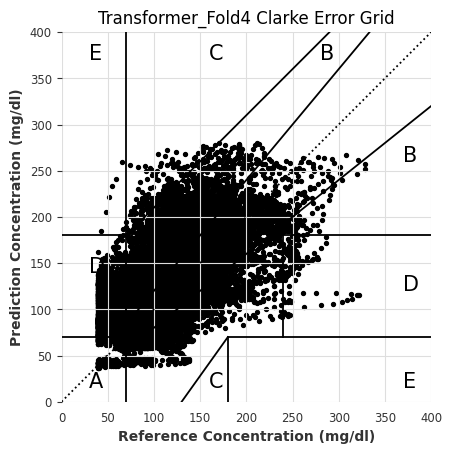

In [150]:
cv_mae = []
cv_rmse = []
# for fold_idx in range(len(all_splits[0])):
for fold_idx in range(3, 4):
    # Prepare data for this fold
    train_series   = [s[fold_idx]['train_ts'] for s in all_splits]
    val_series     = [s[fold_idx]['val_ts']   for s in all_splits]
    train_past     = [s[fold_idx]['train_past'] for s in all_splits]
    val_past       = [s[fold_idx]['val_past']   for s in all_splits]

    # Scale past covariates
    past_scaler = Scaler(StandardScaler(), global_fit=False)
    past_scaler.fit(train_past)
    t_cov = past_scaler.transform(train_past)
    v_cov = past_scaler.transform(val_past)

    # Train model
    model = TransformerModel(
        input_chunk_length=72,
        output_chunk_length=12,
        model_name=f"Transformer_Fold{fold_idx+1}",
        log_tensorboard=True,
        n_epochs=10,
        random_state=42
    )
    
    model.fit(
        series=train_series,
        past_covariates=t_cov,
        val_series=val_series,
        val_past_covariates=v_cov,
        dataloader_kwargs={'num_workers':4},
        verbose=True
    )

    # Forecast & metrics
    fold_preds = []
    maes = []
    rmses = []
    for ts_tr, ts_val, cov_tr, cov_val in zip(train_series, val_series, t_cov, v_cov):
        cov_all = cov_tr.append(cov_val)
        pred = model.predict(n=len(ts_val), series=ts_tr, past_covariates=cov_all)
        fold_preds.append(pred)
        maes.append(mae(ts_val, pred))
        rmses.append(rmse(ts_val, pred))

    avg_mae  = sum(maes)/len(maes)
    avg_rmse = sum(rmses)/len(rmses)
    print(f"Fold {fold_idx+1} — MAE: {avg_mae:.2f}, RMSE: {avg_rmse:.2f}")
    cv_mae.append(avg_mae)
    cv_rmse.append(avg_rmse)

    # Clarke Error Grid
    evaluate_clarke_error(fold_preds, val_series, target_scaler,
                           model_name=f"Transformer_Fold{fold_idx+1}")

print(f"\n✅ Overall CV MAE: {np.mean(cv_mae):.2f}")
print(f"✅ Overall CV RMSE: {np.mean(cv_rmse):.2f}")


In [76]:
len(predictions[1:])

798

In [116]:
full_train_ts  = scaled_cgm_series 
full_train_past = past_covariates  # unscaled past for the 25
# Fit past cov scaler on full set
global_past_scaler = Scaler(StandardScaler(), global_fit=True)
global_past_scaler.fit(full_train_past)
full_train_past_scaled = global_past_scaler.transform(full_train_past)

# Train final transformer on all 25
final_model = TransformerModel(
    input_chunk_length=72,
    output_chunk_length=12,
    model_name="Transformer_Final_All25",
    n_epochs=20,
    log_tensorboard=True,
    random_state=42
)
final_model.fit(
    series=full_train_ts,
    past_covariates=full_train_past_scaled,
    val_series=scaled_holdout_cgm,
    val_past_covariates=holdout_past_scaled,
    dataloader_kwargs={'num_workers':4},
    verbose=True
)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

TransformerModel(output_chunk_shift=0, d_model=64, nhead=4, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=72, output_chunk_length=12, model_name=Transformer_Final_All25, n_epochs=20, log_tensorboard=True, random_state=42)

In [188]:
final_model.save("Transformer_25_patients")

In [28]:
def backtest_model(
    model,
    model_name,
    val_series,
    scaler,
    forecast_horizon=12,
    stride=12,
    retrain=True,
    verbose=True,
    save_dir="model_results",
    past_covariates=None,
    future_covariates=None,
    last_points_only=True
):
    start_time = time.time()
    # historical forecasts
    forecasts = model.historical_forecasts(
        series=val_series,
        past_covariates=past_covariates,
        future_covariates=future_covariates,
        start=0,
        forecast_horizon=forecast_horizon,
        stride=stride,
        retrain=retrain,
        last_points_only=last_points_only,
        verbose=verbose
    )
    total_time = time.time() - start_time
    plot_dir = os.path.join(save_dir, f"{model_name}_plots")
    os.makedirs(plot_dir, exist_ok=True)
    all_maes, all_rmses = [], []
    concatenated_forecasts = []
    all_pred, all_act = [], []
    for i, val_ts in enumerate(val_series):
        fc = forecasts[i]
        if isinstance(fc, list):
            forecast_series = concatenate(fc, axis=0)
        else:
            forecast_series = fc
        concatenated_forecasts.append(forecast_series)
        # plot
        plt.figure(figsize=(10,4))
        scaler.inverse_transform(val_ts).plot(label="Actual")
        scaler.inverse_transform(forecast_series).plot(label="Forecast")
        plt.title(f"{model_name} - Series {i}")
        plt.legend(); plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, f"{model_name}_series_{i}.png"), dpi=300)
        plt.close()
        # metrics
        truth = val_ts.slice_intersect(forecast_series)
        un_pred = scaler.inverse_transform(forecast_series)
        un_act  = scaler.inverse_transform(truth)
        mae_val  = mae(un_act, un_pred)
        rmse_val = rmse(un_act, un_pred)
        all_maes.append(mae_val)
        all_rmses.append(rmse_val)
        all_pred.extend(un_pred.values().flatten())
        all_act.extend(un_act.values().flatten())
    # save metrics
    with open(os.path.join(plot_dir, f"{model_name}_metrics.txt"), 'w') as f:
        f.write(f"Average MAE: {np.mean(all_maes):.4f}\n")
        f.write(f"Average RMSE: {np.mean(all_rmses):.4f}\n")
        f.write(f"Total time: {total_time:.2f}s\n")
    # Clarke
    with open(os.path.join(plot_dir, f"{model_name}_metrics.txt"), 'a') as f:
        f.write("\nClarke Error Grid Analysis:\n")
        _, zones = evaluate_clarke_error(concatenated_forecasts, val_series, scaler, model_name, save_file=f)
        # save plot
        fig, _ = clarke_error_grid(np.array(all_act), np.array(all_pred), model_name)
        fig.savefig(os.path.join(plot_dir, f"{model_name}_clarke_error.png"), dpi=300)
        fig.show()
    return all_maes, all_rmses, total_time, zones

Predicting: |                                                                                                 …


Clarke Error Grid for Transformer_Holdout:
Zone A: 89.22%
Zone B: 8.88%
Zone C: 0.00%
Zone D: 1.90%
Zone E: 0.00%


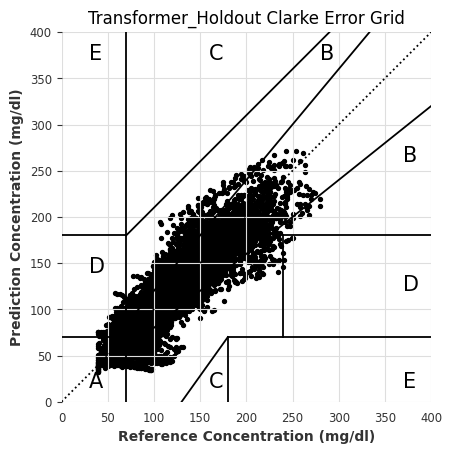

Hold-out MAE: 10.18
Hold-out RMSE: 14.13
Hold-out runtime: 8.82s
Hold-out Clarke zones: [22932, 2283, 0, 489, 0]


In [131]:
holdout_maes, holdout_rmses, holdout_time, holdout_zones = backtest_model(
    model=final_model,
    model_name="Transformer_Holdout",
    val_series=scaled_holdout_cgm,
    scaler=target_scaler,
    forecast_horizon=12,
    stride=12,
    retrain=False,
    verbose=True,
    last_points_only=False,
    save_dir="holdout_results",
    past_covariates=holdout_past_scaled
)
print(f"Hold-out MAE: {np.mean(holdout_maes):.2f}")
print(f"Hold-out RMSE: {np.mean(holdout_rmses):.2f}")
print(f"Hold-out runtime: {holdout_time:.2f}s")
print(f"Hold-out Clarke zones: {holdout_zones}")


In [129]:
min(scaled_holdout_cgm[0].values())

array([0.])

In [ ]:
min(glob scaled_holdout_cgm[0].values())

# Walk Forward Validation

Training: |                                                                                                   …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 1 — MAE: 11.33, RMSE: 13.24

Clarke Error Grid for Transformer_WF_Fold1:
Zone A: 82.00%
Zone B: 10.67%
Zone C: 0.00%
Zone D: 7.33%
Zone E: 0.00%


Training: |                                                                                                   …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 64 — MAE: 17.84, RMSE: 20.43

Clarke Error Grid for Transformer_WF_Fold64:
Zone A: 69.00%
Zone B: 23.00%
Zone C: 0.00%
Zone D: 8.00%
Zone E: 0.00%


Training: |                                                                                                   …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 128 — MAE: 9.00, RMSE: 12.26

Clarke Error Grid for Transformer_WF_Fold128:
Zone A: 93.00%
Zone B: 7.00%
Zone C: 0.00%
Zone D: 0.00%
Zone E: 0.00%


Training: |                                                                                                   …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 192 — MAE: 17.87, RMSE: 20.70

Clarke Error Grid for Transformer_WF_Fold192:
Zone A: 67.67%
Zone B: 32.33%
Zone C: 0.00%
Zone D: 0.00%
Zone E: 0.00%


Training: |                                                                                                   …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 256 — MAE: 9.60, RMSE: 10.81

Clarke Error Grid for Transformer_WF_Fold256:
Zone A: 99.33%
Zone B: 0.67%
Zone C: 0.00%
Zone D: 0.00%
Zone E: 0.00%


Training: |                                                                                                   …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 320 — MAE: 12.74, RMSE: 15.64

Clarke Error Grid for Transformer_WF_Fold320:
Zone A: 93.33%
Zone B: 5.67%
Zone C: 0.00%
Zone D: 1.00%
Zone E: 0.00%


Training: |                                                                                                   …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 384 — MAE: 12.54, RMSE: 13.62

Clarke Error Grid for Transformer_WF_Fold384:
Zone A: 89.67%
Zone B: 8.67%
Zone C: 0.00%
Zone D: 1.67%
Zone E: 0.00%


Training: |                                                                                                   …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 448 — MAE: 9.98, RMSE: 11.71

Clarke Error Grid for Transformer_WF_Fold448:
Zone A: 92.00%
Zone B: 8.00%
Zone C: 0.00%
Zone D: 0.00%
Zone E: 0.00%


Training: |                                                                                                   …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 512 — MAE: 13.02, RMSE: 13.86

Clarke Error Grid for Transformer_WF_Fold512:
Zone A: 93.67%
Zone B: 6.33%
Zone C: 0.00%
Zone D: 0.00%
Zone E: 0.00%


Training: |                                                                                                   …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 576 — MAE: 10.74, RMSE: 12.18

Clarke Error Grid for Transformer_WF_Fold576:
Zone A: 92.67%
Zone B: 6.00%
Zone C: 0.00%
Zone D: 1.33%
Zone E: 0.00%

=== Aggregated Clarke Error Grid for all folds ===

Clarke Error Grid for Transformer_WF_AllFolds:
Zone A: 87.23%
Zone B: 10.83%
Zone C: 0.00%
Zone D: 1.93%
Zone E: 0.00%
Overall WF MAE: 12.47
Overall WF RMSE: 14.45


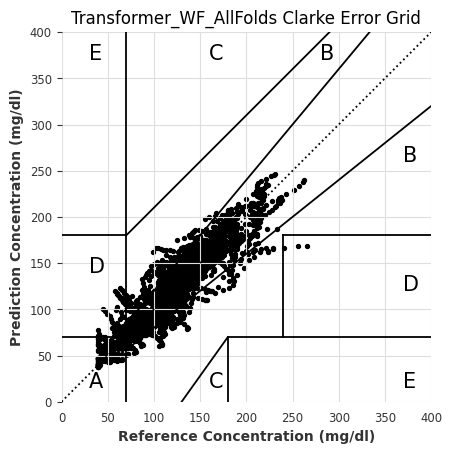

In [32]:
def walk_forward_splits(
    ts: TimeSeries,
    past_cov: TimeSeries,
    initial_train_size: int,
    horizon: int,
    step: int = 1
):
    """
    Generate walk-forward (rolling-origin) validation splits.
    """
    n = len(ts)
    splits = []
    for end_train in range(initial_train_size, n, step):
        start_val = end_train
        end_val = start_val + horizon
        if end_val > n:
            break
        splits.append({
            "train_ts": ts[:end_train],
            "val_ts": ts[start_val:end_val],
            "train_past": past_cov[:end_train],
            "val_past": past_cov[start_val:end_val],
        })
    return splits

# 2) Parameters & data
HORIZON = 12
INITIAL_TRAIN = len(cgm_series[0]) // 5     # first 20% of original series
STEP = 12
N_FOLDS = 10                                # number of folds to run

target_scaler = Scaler(global_fit=True)
target_scaler.fit(cgm_series)
scaled_cgm_series = target_scaler.transform(cgm_series)

# Prepare walk-forward splits on scaled data
all_splits = [
    walk_forward_splits(
        ts=scaled_cgm_series[i],
        past_cov=past_covariates[i],
        initial_train_size=INITIAL_TRAIN,
        horizon=HORIZON,
        step=STEP
    )
    for i in range(len(scaled_cgm_series))
]

# Sample N_FOLDS evenly
available_folds = len(all_splits[0])
fold_indices = np.linspace(0, available_folds - 1, min(N_FOLDS, available_folds), dtype=int)

# 3) Loop over selected folds
all_preds = []
all_vals = []
distinct_mae = []
distinct_rmse = []

for idx in fold_indices:
    fold_idx = int(idx)
    # Gather split data
    train_series = [s[fold_idx]['train_ts'] for s in all_splits]
    val_series   = [s[fold_idx]['val_ts'] for s in all_splits]
    train_past   = [s[fold_idx]['train_past'] for s in all_splits]
    val_past     = [s[fold_idx]['val_past'] for s in all_splits]

    # Scale covariates per fold
    past_scaler = Scaler(StandardScaler(), global_fit=False)
    past_scaler.fit(train_past)
    t_cov = past_scaler.transform(train_past)
    v_cov = past_scaler.transform(val_past)

    # Initialize & train model
    model = TransformerModel(
        input_chunk_length=72,
        output_chunk_length=HORIZON,
        model_name=f"Transformer_WF_Fold{fold_idx+1}",
        log_tensorboard=True,
        n_epochs=10,
        random_state=42
    )
    model.fit(
        series=train_series,
        past_covariates=t_cov,
        verbose=True
    )

    # Forecast & evaluate per patient (unscaled)
    fold_preds = []
    maes, rmses = [], []
    for ts_tr, ts_val, cov_tr, cov_val in zip(train_series, val_series, t_cov, v_cov):
        # predict on scaled
        cov_all = cov_tr.append(cov_val)
        scaled_pred = model.predict(
            n=len(ts_val),
            series=ts_tr,
            past_covariates=cov_all
        )
        # invert scaling
        orig_val  = target_scaler.inverse_transform(ts_val)
        orig_pred = target_scaler.inverse_transform(scaled_pred)

        fold_preds.append(orig_pred)
        maes.append(mae(orig_val, orig_pred))
        rmses.append(rmse(orig_val, orig_pred))

    # Collect for overall aggregation
    all_preds.extend(fold_preds)
    all_vals.extend([target_scaler.inverse_transform(v) for v in val_series])

    # Store and print per-fold metrics (original scale)
    fold_mae  = np.mean(maes)
    fold_rmse = np.mean(rmses)
    distinct_mae.append(fold_mae)
    distinct_rmse.append(fold_rmse)
    print(f"Fold {fold_idx+1} — MAE: {fold_mae:.2f}, RMSE: {fold_rmse:.2f}")

    # Clarke Error Grid for this fold
    evaluate_clarke_error(
        fold_preds,
        [target_scaler.inverse_transform(v) for v in val_series],
        model_name=f"Transformer_WF_Fold{fold_idx+1}"
    )

# 4) Overall aggregated Clarke Error Grid
print("\n=== Aggregated Clarke Error Grid for all folds ===")
evaluate_clarke_error(
    all_preds,
    all_vals,
    model_name="Transformer_WF_AllFolds"
)

# 5) Overall CV results in original scale
print(f"Overall WF MAE: {np.mean(distinct_mae):.2f}")
print(f"Overall WF RMSE: {np.mean(distinct_rmse):.2f}")

# ARIMA


=== ARIMA Walk-Forward CV ===
ARIMA Fold 1: MAE=7.66, RMSE=9.28

Clarke Error Grid for ARIMA_Fold1:
Zone A: 92.00%
Zone B: 2.33%
Zone C: 0.00%
Zone D: 5.67%
Zone E: 0.00%
ARIMA Fold 64: MAE=12.04, RMSE=14.61

Clarke Error Grid for ARIMA_Fold64:
Zone A: 80.33%
Zone B: 14.67%
Zone C: 0.00%
Zone D: 5.00%
Zone E: 0.00%
ARIMA Fold 128: MAE=11.33, RMSE=14.08

Clarke Error Grid for ARIMA_Fold128:
Zone A: 93.00%
Zone B: 7.00%
Zone C: 0.00%
Zone D: 0.00%
Zone E: 0.00%
ARIMA Fold 192: MAE=6.55, RMSE=8.00

Clarke Error Grid for ARIMA_Fold192:
Zone A: 94.00%
Zone B: 6.00%
Zone C: 0.00%
Zone D: 0.00%
Zone E: 0.00%
ARIMA Fold 256: MAE=16.82, RMSE=21.22

Clarke Error Grid for ARIMA_Fold256:
Zone A: 76.33%
Zone B: 22.67%
Zone C: 0.00%
Zone D: 1.00%
Zone E: 0.00%
ARIMA Fold 320: MAE=32.38, RMSE=38.87

Clarke Error Grid for ARIMA_Fold320:
Zone A: 55.00%
Zone B: 44.00%
Zone C: 0.00%
Zone D: 1.00%
Zone E: 0.00%
ARIMA Fold 384: MAE=12.19, RMSE=15.29

Clarke Error Grid for ARIMA_Fold384:
Zone A: 79.67%
Zon

(<module 'matplotlib.pyplot' from '/home/smitsis/glucose_level_prediction/.venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>,
 [2516, 413, 0, 71, 0])

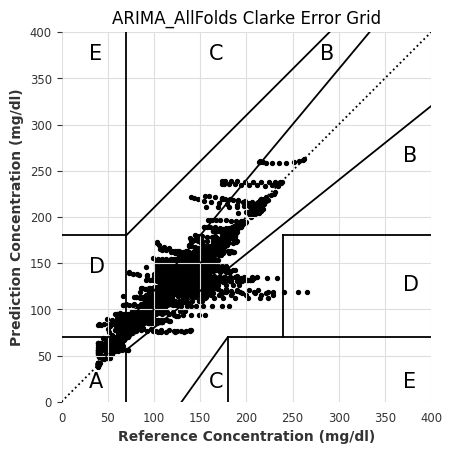

In [20]:
def walk_forward_splits(ts: TimeSeries, past_cov: TimeSeries, initial_train_size: int,
                         horizon: int, step: int = 1):
    n = len(ts)
    splits = []
    for end_train in range(initial_train_size, n, step):
        if end_train + horizon > n:
            break
        splits.append({
            "train_ts":   ts[:end_train],
            "val_ts":     ts[end_train:end_train + horizon],
            "train_past": past_cov[:end_train],
            "val_past":   past_cov[end_train:end_train + horizon],
        })
    return splits

# 2) Global parameters & data (unchanged)
HORIZON = 12
INITIAL_TRAIN = len(cgm_series[0]) // 5
STEP = 12
N_FOLDS = 10

# scale target globally
target_scaler = Scaler(global_fit=True)
target_scaler.fit(cgm_series)
scaled_series = target_scaler.transform(cgm_series)

# prepare all splits
all_splits = [
    walk_forward_splits(scaled_series[i], past_covariates[i], INITIAL_TRAIN, HORIZON, STEP)
    for i in range(len(scaled_series))
]
available = len(all_splits[0])
fold_indices = np.linspace(0, available - 1, min(N_FOLDS, available), dtype=int)

# 3) ARIMA Walk-Forward CV only
print("\n=== ARIMA Walk-Forward CV ===")
arima_mae, arima_rmse = [], []
all_preds, all_vals = [], []

for fold_idx in fold_indices:
    # gather train/val splits
    ts_tr  = [s[fold_idx]['train_ts'] for s in all_splits]
    ts_val = [s[fold_idx]['val_ts']   for s in all_splits]

    fold_preds, maes, rmses = [], [], []
    for tr, val in zip(ts_tr, ts_val):

        arima_model = ARIMA(p=12, d=1, q=1)  
        arima_model.fit(tr)
        pred_s = arima_model.predict(len(val))

        # unscale
        orig_val  = target_scaler.inverse_transform(val).pd_series()
        orig_pred = target_scaler.inverse_transform(pred_s).pd_series()

        # back to TimeSeries
        ts_v = TimeSeries.from_series(orig_val)
        ts_p = TimeSeries.from_series(orig_pred)

        fold_preds.append(ts_p)
        maes.append(mae(ts_v, ts_p))
        rmses.append(rmse(ts_v, ts_p))

        all_vals.append(ts_v)
        all_preds.append(ts_p)

    m, r = np.mean(maes), np.mean(rmses)
    arima_mae.append(m)
    arima_rmse.append(r)
    print(f"ARIMA Fold {fold_idx+1}: MAE={m:.2f}, RMSE={r:.2f}")

    # per-fold Clarke Error Grid
    evaluate_clarke_error(
        fold_preds,
        [target_scaler.inverse_transform(v) for v in ts_val],
        model_name=f"ARIMA_Fold{fold_idx+1}"
    )

# overall metrics & Clarke grid
print("\nARIMA Overall:")
print(f"MAE={np.mean(arima_mae):.2f}, RMSE={np.mean(arima_rmse):.2f}")
evaluate_clarke_error(
    all_preds,
    all_vals,
    model_name="ARIMA_AllFolds"
)


# Full train 10 epochs

In [34]:
excluded_ids = ["child#001", "adult#001", "adolescent#001"]

# 2) Read & preprocess only the hold-out CSVs
holdout_series = []
for csv_path in glob.glob(os.path.join(folder_path, "*.csv")):
    pid = os.path.basename(csv_path).split(".")[0]
    if pid not in excluded_ids:
        continue

    df = pd.read_csv(csv_path)
    df["Time"] = pd.to_datetime(df["Time"])
    df["time_idx"] = (df["Time"].astype(int) // 10**9) // 300
    df["time_idx"] -= df["time_idx"].min()
    df["hour"] = df["Time"].dt.hour
    df = df.drop(columns=["Time"])

    holdout_series.append(TimeSeries.from_dataframe(df, time_col="time_idx"))

holdout_cgm = [ts["CGM"] for ts in holdout_series]
scaled_holdout_cgm = target_scaler.transform(holdout_cgm)

# 4) Recreate & scale their past covariates
holdout_past = [create_past_covariates(ts).astype(np.float32) for ts in holdout_series]
holdout_past_scaled = global_past_scaler.transform(holdout_past)


final_model_10 = TransformerModel(
    input_chunk_length=72,
    output_chunk_length=12,
    model_name="Transformer_Final_All_20_25",
    n_epochs=20,
    log_tensorboard=True,
    random_state=42
)

# 5) Now you can fit with validation loss:
final_model_10.fit(
    series=full_train_ts,
    past_covariates=full_train_past_scaled,
    val_series=scaled_holdout_cgm,
    val_past_covariates=holdout_past_scaled,
    dataloader_kwargs={'num_workers':4},
    verbose=True
)

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

TransformerModel(output_chunk_shift=0, d_model=64, nhead=4, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=72, output_chunk_length=12, model_name=Transformer_Final_All_20_25, n_epochs=20, log_tensorboard=True, random_state=42)

Predicting: |                                                                                                 …


Clarke Error Grid for Transformer_Holdout:
Zone A: 89.22%
Zone B: 8.88%
Zone C: 0.00%
Zone D: 1.90%
Zone E: 0.00%


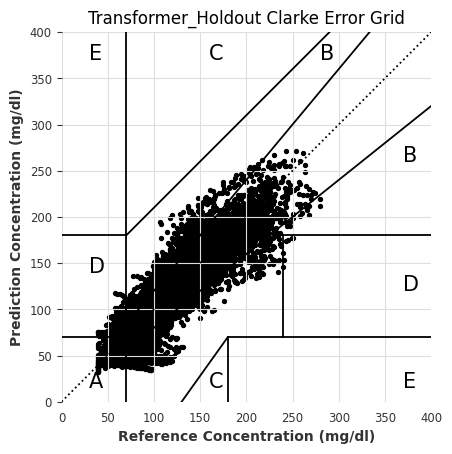

Hold-out MAE:  10.18
Hold-out RMSE: 14.13
Hold-out runtime: 5.74s
Hold-out Clarke zones: [22932, 2283, 0, 489, 0]


In [35]:
holdout_maes, holdout_rmses, holdout_time, holdout_zones = backtest_model(
    model=final_model_10,
    model_name="Transformer_Holdout",
    val_series=scaled_holdout_cgm,
    scaler=target_scaler,
    forecast_horizon=12,
    stride=12,
    retrain=False,
    verbose=True,
    last_points_only=False,
    save_dir="holdout_results",
    past_covariates=holdout_past_scaled
)

print(f"Hold-out MAE:  {np.mean(holdout_maes):.2f}")
print(f"Hold-out RMSE: {np.mean(holdout_rmses):.2f}")
print(f"Hold-out runtime: {holdout_time:.2f}s")
print(f"Hold-out Clarke zones: {holdout_zones}")

# ARIMA holdout

In [ ]:
arima_model = ARIMA(p=12, d=1, q=1)

# 2) Backtest on the same 3 hold-outs
holdout_maes_arima, holdout_rmses_arima, holdout_time_arima, holdout_zones_arima = backtest_model(
    model            = arima_model,
    model_name       = "ARIMA_Holdout",
    val_series       = scaled_holdout_cgm,   
    scaler           = target_scaler,
    forecast_horizon = 12,
    stride           = 12,
    retrain          = False,
    verbose          = True,
    last_points_only = False,
    save_dir         = "arima_results",      
    past_covariates  = None,                 
    future_covariates= None,
)

print(f"ARIMA Hold-out MAE:  {np.mean(holdout_maes_arima):.2f}")
print(f"ARIMA Hold-out RMSE: {np.mean(holdout_rmses_arima):.2f}")
print(f"ARIMA Hold-out runtime: {holdout_time_arima:.2f}s")
print(f"ARIMA Hold-out Clarke zones: {holdout_zones_arima}")